<a href="https://colab.research.google.com/github/rockey1006/Variations-on-Variational-Autoencoders/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://github.com/frsong/tf-examples/blob/master/vae.py
# https://medium.com/@cotra.marko/making-sense-of-the-kullback-leibler-kl-divergence-b0d57ee10e0a

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [15]:
# Load the data
data = input_data.read_data_sets('datasets/mnist', one_hot=True)

Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz


In [0]:
#-------------------------------------------------------------------------------
# Model
#-------------------------------------------------------------------------------

# Latent space dimension
latent_dim = 2

def weight(shape):
    """ Generates random uniform weights as tf variable
    Argemunets:  shape (list) of values  [x1 = dimension, x2 = latest space]
    Returns:     <tf.Variable 'W:0' shape=(x1, x2) dtype=float32_ref>
    """
    bound = np.sqrt(6.0 / np.sum(shape))
    W = tf.random_uniform(shape, -bound, bound)
    return tf.Variable(W, name='W')

def bias(shape):
    """ Generates bias of 0 as tf variable
    Arguments:  shape (list) of values [x1 = dimension, x2 = latest space]
    Returns:    <tf.Variable 'b:0' shape=(x1, x2) dtype=float32_ref>
    """
    b = tf.constant(0.0, shape=shape)
    return tf.Variable(b, name='b')

def linear(name, x, dim):
    """ Evaluates x times W + b and fits it to dim dimension
    Arguments:  name (str) name of the scope encoder or decoder
                x (tf.Variable) input
                dim (int) dimension to fit to
    Returns:    new layer's values evaluated with linear function
    """
    with tf.name_scope(name):
        W = weight([x.get_shape()[-1].value, dim])
        b = bias([dim])
    return tf.matmul(x, W) + b

def encoder(x, hidden_dim=500):
    """ Performs feedforward calculations for the neural network:
    input -> hidden layer -> softplus -> hidden layer -> softplus -> dense
    Softplus is  x -> max(0, x)
    """
    with tf.name_scope('encoder'):
        x = linear('hidden_1', x, hidden_dim)
        x = tf.nn.softplus(x)
        x = linear('hidden_2', x, hidden_dim)
        x = tf.nn.softplus(x)
        z_mean    = linear('mean', x, latent_dim)
        z_log_var = linear('log_var', x, latent_dim)

    return z_mean, z_log_var

def decoder(x, hidden_dim=500):
    """ Performs feedforward calculations for the decode part of the network:
    dense -> hidden -> softplus -> hidden -> softplus -> reconstruction
    """
    with tf.name_scope('decoder'):
        x = linear('hidden_1', x, hidden_dim)
        x = tf.nn.softplus(x)
        x = linear('hidden_2', x, hidden_dim)
        x = tf.nn.softplus(x)
        x = linear('reconstruction', x, 784)

    return x

In [17]:
# Seed the TF random number generator for reproducible initialization
tf.set_random_seed(0)

# For feeding in data
x = tf.placeholder(tf.float32, [None, 784])

# Model
z_mean, z_log_var = encoder(x)
epsilon = tf.random_normal(tf.shape(z_log_var))
z = z_mean + epsilon * tf.exp(0.5*z_log_var)  # "Reparametrization trick"
logits = decoder(z)
reconstruction = tf.nn.sigmoid(logits)

# Reconstruction loss
CE = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x)
CE = tf.reduce_sum(CE, 1)

# Latent loss
KL = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
KL = -0.5 * tf.reduce_sum(KL, 1)

# Total loss
loss = tf.reduce_mean(CE + KL)

# Hyperparameters
learning_rate = 0.001
num_epochs    = 10
batch_size    = 100

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op  = optimizer.minimize(loss)

# Seed the random number generator for reproducible batches
np.random.seed(0)

# Print list of variables
print("")
print("Variables")
print("---------")
variables  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
num_params = 0
for v in variables:
    num_params += np.prod(v.get_shape().as_list())
    print(v.name, v.get_shape())
print("=> Total number of parameters =", num_params)



Variables
---------
encoder/hidden_1/W:0 (784, 500)
encoder/hidden_1/b:0 (500,)
encoder/hidden_2/W:0 (500, 500)
encoder/hidden_2/b:0 (500,)
encoder/mean/W:0 (500, 2)
encoder/mean/b:0 (2,)
encoder/log_var/W:0 (500, 2)
encoder/log_var/b:0 (2,)
decoder/hidden_1/W:0 (2, 500)
decoder/hidden_1/b:0 (500,)
decoder/hidden_2/W:0 (500, 500)
decoder/hidden_2/b:0 (500,)
decoder/reconstruction/W:0 (500, 784)
decoder/reconstruction/b:0 (784,)
encoder_1/hidden_1/W:0 (784, 500)
encoder_1/hidden_1/b:0 (500,)
encoder_1/hidden_2/W:0 (500, 500)
encoder_1/hidden_2/b:0 (500,)
encoder_1/mean/W:0 (500, 2)
encoder_1/mean/b:0 (2,)
encoder_1/log_var/W:0 (500, 2)
encoder_1/log_var/b:0 (2,)
decoder_1/hidden_1/W:0 (2, 500)
decoder_1/hidden_1/b:0 (500,)
decoder_1/hidden_2/W:0 (500, 500)
decoder_1/hidden_2/b:0 (500,)
decoder_1/reconstruction/W:0 (500, 784)
decoder_1/reconstruction/b:0 (784,)
=> Total number of parameters = 2579576


In [18]:
# TF session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Minimize the loss function
num_batches_per_epoch = data.train.num_examples // batch_size

for epoch in range(num_epochs):
    current_loss = 0
    
    for _ in range(num_batches_per_epoch):
        
        batch_x, _ = data.train.next_batch(batch_size)
        
        _, loss_val = sess.run([train_op, loss], {x: batch_x})
        
        current_loss += loss_val

    if (epoch+1) % 5 == 0:
        print("After {} epochs, loss = {}"
              .format(epoch+1, current_loss/num_batches_per_epoch))

def encode(x_):
    return sess.run(z_mean, {x: x_})

def generate(z_):
    return sess.run(reconstruction, {z: z_})

def reconstruct(x_):
    return sess.run(reconstruction, {x: x_})

After 5 epochs, loss = 155.77815468528053
After 10 epochs, loss = 149.2674336381392


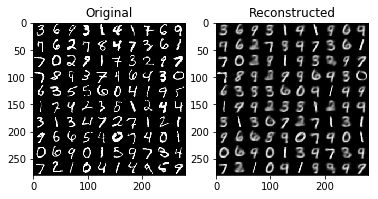

In [19]:
#-------------------------------------------------------------------------------
# Example reconstructions
#-------------------------------------------------------------------------------

nx = ny = 10
images = data.test.images[:nx*ny]
reconstructed_images = reconstruct(images)

grid = np.zeros((28*ny, 28*nx))
reconstructed_grid = np.zeros((28*ny, 28*nx))
for i in range(ny):
    for j in range(nx):
        grid[28*(ny-i-1):28*(ny-i),28*j:28*(j+1)] = (
            images[i*ny+j].reshape((28, 28))
            )
        reconstructed_grid[28*(ny-i-1):28*(ny-i),28*j:28*(j+1)] = (
            reconstructed_images[i*ny+j].reshape((28, 28))
            )

plt.figure()

# Original images
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(grid, cmap='gray')

# Reconstructed images
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(reconstructed_grid, cmap='gray')

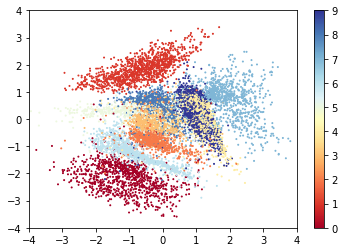

In [20]:
#-------------------------------------------------------------------------------
# Plot latent embedding
#-------------------------------------------------------------------------------

if latent_dim == 2:
    images = data.test.images
    labels = data.test.labels
    z_mu   = encode(images)

    colorful = plt.cm.get_cmap('RdYlBu')
    plt.figure()
    plt.scatter(z_mu[:,0], z_mu[:,1], 
                c=np.argmax(labels, 1), cmap=colorful, s=1)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.colorbar()

In [21]:
z_mu

array([[ 2.383918  ,  0.9090076 ],
       [-0.0918448 , -0.7302424 ],
       [-1.0567242 ,  2.117943  ],
       ...,
       [ 0.9546414 ,  0.8569549 ],
       [-1.8505183 ,  0.34509292],
       [-1.1334888 , -1.2231019 ]], dtype=float32)

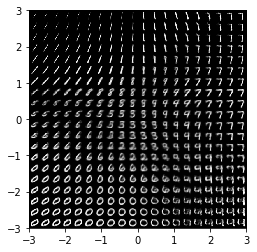

In [22]:
#-------------------------------------------------------------------------------
# Plot samples at corresponding latent space positions
#-------------------------------------------------------------------------------

if latent_dim == 2:
    nx = ny = 20
    xs = np.linspace(-3, 3, nx)
    ys = np.linspace(-3, 3, ny)

    grid = np.zeros((28*ny, 28*nx))
    for i, y_i in enumerate(ys):
        for j, x_j in enumerate(xs):
            latent = [[x_j, y_i]]
            image  = generate(latent)[0]
            grid[28*(ny-i-1):28*(ny-i),28*j:28*(j+1)] = image.reshape((28, 28))

    plt.figure()
    plt.imshow(grid, cmap='gray', extent=[-3, 3, -3, 3])

In [23]:
from IPython.display import clear_output, Image, display, HTML
from google.colab import files

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# """Tensorboard"""
my_graph = tf.get_default_graph().as_graph_def()
show_graph(my_graph)